In [1]:
!pip install mxnet=="1.4.1"

    100% |████████████████████████████████| 28.4MB 1.9MB/s eta 0:00:011
You are using pip version 10.0.1, however version 19.3.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
!pip install gluonts

    100% |████████████████████████████████| 327kB 49.1MB/s ta 0:00:01
    100% |████████████████████████████████| 61kB 47.3MB/s ta 0:00:01
    100% |████████████████████████████████| 194kB 60.8MB/s eta 0:00:01
    100% |████████████████████████████████| 7.1MB 7.4MB/s eta 0:00:011
  Using cached https://files.pythonhosted.org/packages/41/17/c62faccbfbd163c7f57f3844689e3a78bae1f403648a6afb1d0866d87fbb/python_dateutil-2.8.0-py2.py3-none-any.whl
    100% |████████████████████████████████| 10.4MB 5.2MB/s eta 0:00:01
    100% |████████████████████████████████| 81kB 47.4MB/s ta 0:00:01
  Running setup.py bdist_wheel for ujson ... done
  Stored in directory: /home/ec2-user/.cache/pip/wheels/28/77/e4/0311145b9c2e2f01470e744855131f9e34d6919687550f87d1
  Running setup.py bdist_wheel for holidays ... done
  Stored in directory: /home/ec2-user/.cache/pip/wheels/40/a9/2b/94ac5464363d37564a87dc93a9d21a5850aac14a4608197003
Successfully built ujson holidays
  Found existing installation: python-dateuti

In [3]:
# !pip install gluonts=="0.4.1"

In [4]:
import gluonts
import mxnet

print(gluonts.__version__)
print(mxnet.__version__)

0.4.2
1.4.1


In [5]:
# standard imports
import numpy as np
import pandas as pd

# Vis
%matplotlib inline
import matplotlib.pyplot as plt
from pprint import pprint

# mxnet
import mxnet as mx

# gluonts
from gluonts.dataset.util import to_pandas

# imports from utility function
import utils_gluonts10 as utils
from utils_gluonts10 import get_dataset, dataset_recipes
from utils_gluonts10_deepar import deepar
# from utils_gluonts11_deepstate import deep_state


INFO:root:Using CPU


In [6]:
print(f"Available datasets: {list(dataset_recipes.keys())}")

Available datasets: ['m4_daily', 'm4_daily_domain', 'm4_hourly', 'm4_monthly', 'm4_monthly_atm', 'm4_monthly_dates', 'm4_monthly_demographic', 'm4_monthly_domain', 'm4_monthly_finance', 'm4_monthly_industry', 'm4_monthly_macro', 'm4_monthly_micro', 'm4_monthly_other', 'm4_quarterly', 'm4_quarterly_atm', 'm4_quarterly_dates', 'm4_quarterly_demographic', 'm4_quarterly_domain', 'm4_quarterly_finance', 'm4_quarterly_industry', 'm4_quarterly_macro', 'm4_quarterly_micro', 'm4_quarterly_other', 'm4_weekly', 'm4_weekly_domain', 'my_weekly_tm', 'm4_yearly', 'm4_yearly_demographic', 'm4_yearly_domain', 'm4_yearly_finance', 'm4_yearly_industry', 'm4_yearly_macro', 'm4_yearly_micro', 'm4_yearly_other']


#### Note

In SageMaker data are saved into the following folders (example shows m4_weekly):

```
saving time-series into /home/ec2-user/.mxnet/gluon-ts/datasets/m4_weekly/train/data.json
saving time-series into /home/ec2-user/.mxnet/gluon-ts/datasets/m4_weekly/test/data.json
```

In [8]:
dataname = "m4_weekly"
dataset = get_dataset(dataname, regenerate=False)

INFO:root:downloading and processing m4_weekly


saving time-series into /home/ec2-user/.mxnet/gluon-ts/datasets/m4_weekly/train/data.json
saving time-series into /home/ec2-user/.mxnet/gluon-ts/datasets/m4_weekly/test/data.json


In [9]:
# get the first time series in the training set
train_entry = next(iter(dataset.train))
test_entry = next(iter(dataset.test))

# check keys
print(train_entry.keys())
print(test_entry.keys())

dict_keys(['start', 'target', 'feat_static_cat', 'source'])
dict_keys(['start', 'target', 'feat_static_cat', 'source'])


In [10]:
train_entry

{'start': Timestamp('1750-01-04 00:00:00', freq='W-SUN'),
 'target': array([ 1089.2 ,  1078.91,  1079.88, ..., 36565.18, 36565.18, 35397.16],
       dtype=float32),
 'feat_static_cat': array([0], dtype=int32),
 'source': SourceContext(source=Span(path=PosixPath('/home/ec2-user/.mxnet/gluon-ts/datasets/m4_weekly/train/data.json'), line=1), row=1)}

## Plot Series

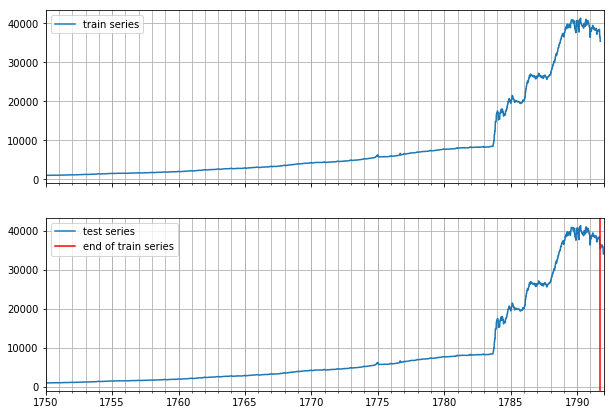

In [11]:
test_series = to_pandas(test_entry)
train_series = to_pandas(train_entry)

fig, ax = plt.subplots(2, 1, sharex=True, sharey=True, figsize=(10, 7))

train_series.plot(ax=ax[0])
ax[0].grid(which="both")
ax[0].legend(["train series"], loc="upper left")

test_series.plot(ax=ax[1])
ax[1].axvline(train_series.index[-1], color='r') # end of train dataset
ax[1].grid(which="both")
ax[1].legend(["test series", "end of train series"], loc="upper left")

plt.show()

In [12]:
print("start:", dict(train_entry)["start"])
print("target:", dict(train_entry)["target"][:7])
print("feat_static_cat:", dict(train_entry)["feat_static_cat"])
print("length:", len(dataset.train))

start: 1750-01-04 00:00:00
target: [1089.2  1078.91 1079.88 1063.58 1060.61 1056.93 1056.63]
feat_static_cat: [0]
length: 359


In [13]:
from gluonts.trainer import Trainer
from gluonts.evaluation.backtest import make_evaluation_predictions
from gluonts.evaluation import Evaluator

from gluonts.model.deepstate import DeepStateEstimator

INFO:root:Using CPU


In [14]:
#########################
### deepstate wrapper ###

# data = "m4_yearly_other"
# seed = 44
# epochs = 500
# num_batches = 100
# batch_size = 32

def deepstate(dataname, seed=42, epochs=100, num_batches=50):
    
    mx.random.seed(seed)
    np.random.seed(seed)

    dataset = get_dataset(dataname, regenerate=False)

    trainer = Trainer(
        ctx=mx.cpu(0),
        epochs=epochs,
        num_batches_per_epoch=num_batches,
        learning_rate=1e-3,
        )

    cardinality = int(dataset.metadata.feat_static_cat[0].cardinality)
    estimator = DeepStateEstimator(
        trainer=trainer,
        cardinality=[cardinality],
        prediction_length=dataset.metadata.prediction_length,
        freq=dataset.metadata.freq,
        use_feat_static_cat=True,
        )

    predictor=estimator.train(dataset.train)

    forecast_it, ts_it = make_evaluation_predictions(
            dataset.test, predictor=predictor, num_samples=100
        )

    agg_metrics, item_metrics = Evaluator()(
        ts_it, forecast_it, num_series=len(dataset.test)
    )

    metrics = ["MASE", "sMAPE", "MSIS", "wQuantileLoss[0.5]", "wQuantileLoss[0.9]"]
    output = {key: round(value, 8) for key, value in agg_metrics.items() if key in metrics}

    output["seed"] = seed
    output["epochs"] = epochs
    output["num_batches"] = num_batches    

    df = pd.DataFrame([output])
    return df

## Results

## `m4_hourly`

In [ ]:
results = pd.DataFrame()

for i in range(43, 45):
    print("Seed:", i)
    df=deepstate("m4_hourly", seed=i, epochs=100, num_batches=50)
    pprint(df)
    results = results.append(df)

results

INFO:root:downloading and processing m4_hourly


Seed: 42
saving time-series into /home/ec2-user/.mxnet/gluon-ts/datasets/m4_hourly/train/data.json


INFO:root:Start model training
INFO:root:Epoch[0] Learning rate is 0.001
  0%|          | 0/50 [00:00<?, ?it/s]

saving time-series into /home/ec2-user/.mxnet/gluon-ts/datasets/m4_hourly/test/data.json


INFO:root:Number of parameters in DeepStateTrainingNetwork: 52087
100%|██████████| 50/50 [03:08<00:00,  3.76s/it, avg_epoch_loss=0.126]
INFO:root:Epoch[0] Elapsed time 188.213 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=0.125870
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [02:33<00:00,  3.07s/it, avg_epoch_loss=-.541]  
INFO:root:Epoch[1] Elapsed time 153.354 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=-0.540530
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [02:57<00:00,  3.55s/it, avg_epoch_loss=-1.1] 
INFO:root:Epoch[2] Elapsed time 177.395 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=-1.104551
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [04:07<00:00,  4.95s/it, avg_epoch_loss=-1.31]
INFO:root:Epoch[3] Elapsed time 247.583 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=-1.307508
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [04:09<00:00,  4.99s/it, avg_e

INFO:root:Epoch[37] Learning rate is 0.001
100%|██████████| 50/50 [04:05<00:00,  4.91s/it, avg_epoch_loss=-2.05]
INFO:root:Epoch[37] Elapsed time 245.308 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=-2.047909
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 50/50 [03:58<00:00,  4.76s/it, avg_epoch_loss=-2.09]
INFO:root:Epoch[38] Elapsed time 238.063 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=-2.086480
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 50/50 [03:52<00:00,  4.65s/it, avg_epoch_loss=-2.11]
INFO:root:Epoch[39] Elapsed time 232.382 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=-2.112923
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 50/50 [04:02<00:00,  4.85s/it, avg_epoch_loss=-2.11]
INFO:root:Epoch[40] Elapsed time 242.527 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=-2.113783
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 50/50 [04:09<00:00,  4.99s/it, avg_epoch_loss=-2

INFO:root:Epoch[75] Learning rate is 0.001
100%|██████████| 50/50 [04:10<00:00,  5.01s/it, avg_epoch_loss=-2.23]
INFO:root:Epoch[75] Elapsed time 250.753 seconds
INFO:root:Epoch[75] Evaluation metric 'epoch_loss'=-2.229298
INFO:root:Epoch[76] Learning rate is 0.001
100%|██████████| 50/50 [04:09<00:00,  4.99s/it, avg_epoch_loss=-2.3] 
INFO:root:Epoch[76] Elapsed time 249.460 seconds
INFO:root:Epoch[76] Evaluation metric 'epoch_loss'=-2.299707
INFO:root:Epoch[77] Learning rate is 0.001
100%|██████████| 50/50 [04:10<00:00,  5.00s/it, avg_epoch_loss=-2.25]
INFO:root:Epoch[77] Elapsed time 250.147 seconds
INFO:root:Epoch[77] Evaluation metric 'epoch_loss'=-2.247422
INFO:root:Epoch[78] Learning rate is 0.001
100%|██████████| 50/50 [04:08<00:00,  4.98s/it, avg_epoch_loss=-2.21]
INFO:root:Epoch[78] Elapsed time 248.793 seconds
INFO:root:Epoch[78] Evaluation metric 'epoch_loss'=-2.205332
INFO:root:Epoch[79] Learning rate is 0.001
100%|██████████| 50/50 [04:08<00:00,  4.97s/it, avg_epoch_loss=-2

       MASE     sMAPE       MSIS  wQuantileLoss[0.5]  wQuantileLoss[0.9]  \
0  1.190507  0.137269  17.358365            0.036605            0.017046   

   seed  epochs  num_batches  
0    42     100           50  
Seed: 43


INFO:root:Number of parameters in DeepStateTrainingNetwork: 52087
100%|██████████| 50/50 [04:52<00:00,  5.86s/it, avg_epoch_loss=0.183]
INFO:root:Epoch[0] Elapsed time 292.991 seconds
INFO:root:Epoch[0] Evaluation metric 'epoch_loss'=0.183459
INFO:root:Epoch[1] Learning rate is 0.001
100%|██████████| 50/50 [04:10<00:00,  5.00s/it, avg_epoch_loss=-.475] 
INFO:root:Epoch[1] Elapsed time 250.110 seconds
INFO:root:Epoch[1] Evaluation metric 'epoch_loss'=-0.475484
INFO:root:Epoch[2] Learning rate is 0.001
100%|██████████| 50/50 [04:08<00:00,  4.98s/it, avg_epoch_loss=-1.11]
INFO:root:Epoch[2] Elapsed time 248.796 seconds
INFO:root:Epoch[2] Evaluation metric 'epoch_loss'=-1.109935
INFO:root:Epoch[3] Learning rate is 0.001
100%|██████████| 50/50 [04:09<00:00,  5.00s/it, avg_epoch_loss=-1.39]
INFO:root:Epoch[3] Elapsed time 249.848 seconds
INFO:root:Epoch[3] Evaluation metric 'epoch_loss'=-1.387334
INFO:root:Epoch[4] Learning rate is 0.001
100%|██████████| 50/50 [04:09<00:00,  5.00s/it, avg_ep

INFO:root:Epoch[37] Learning rate is 0.001
100%|██████████| 50/50 [03:48<00:00,  4.57s/it, avg_epoch_loss=-2.05]
INFO:root:Epoch[37] Elapsed time 228.365 seconds
INFO:root:Epoch[37] Evaluation metric 'epoch_loss'=-2.048817
INFO:root:Epoch[38] Learning rate is 0.001
100%|██████████| 50/50 [04:08<00:00,  4.97s/it, avg_epoch_loss=-2.08]
INFO:root:Epoch[38] Elapsed time 248.485 seconds
INFO:root:Epoch[38] Evaluation metric 'epoch_loss'=-2.082930
INFO:root:Epoch[39] Learning rate is 0.001
100%|██████████| 50/50 [04:09<00:00,  4.98s/it, avg_epoch_loss=-2.13]
INFO:root:Epoch[39] Elapsed time 249.084 seconds
INFO:root:Epoch[39] Evaluation metric 'epoch_loss'=-2.125817
INFO:root:Epoch[40] Learning rate is 0.001
100%|██████████| 50/50 [04:10<00:00,  5.01s/it, avg_epoch_loss=-2.12]
INFO:root:Epoch[40] Elapsed time 250.406 seconds
INFO:root:Epoch[40] Evaluation metric 'epoch_loss'=-2.120269
INFO:root:Epoch[41] Learning rate is 0.001
100%|██████████| 50/50 [04:09<00:00,  4.99s/it, avg_epoch_loss=-2